In [1]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb

use_xgb=True #disable for speed

from subprocess import check_output
datadir="./input/"
print(check_output(["ls", datadir]).decode("utf8"))

%matplotlib inline  


Using TensorFlow backend.


test.csv.zip
train.csv.zip



In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        
def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [41]:
# XGB!

def xgbfit(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
#my first tries:
    xgb_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.075,
        'objective': 'reg:linear',
        'max_depth': 6,
        'num_parallel_tree': 1,
        'min_child_weight': 1,
        'eval_metric': 'mae',
    }
    #params from:
    #https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
    xgb_params = {
        'seed': 0,
        'colsample_bytree': 0.3085,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.01,
        'objective': 'reg:linear',
        'max_depth': 7,
        'num_parallel_tree': 1,
        'min_child_weight': 4.2922,
        'eval_metric': 'mae',
        'eta':0.001,
        'gamma': 0.5290,
        'subsample':0.9930,
        'max_delta_step':0,
        'booster':'gbtree',
        'nrounds': 1001
    }

    start_time = time.time()
    res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
                 early_stopping_rounds=25, verbose_eval=100, show_stdv=True, maximize=False)
    print("CV time:{}s".format(round((time.time()-start_time), 3) ))

    best_nrounds = res.shape[0] - 1
    cv_mean = res.iloc[-1, 0]
    cv_std = res.iloc[-1, 1]
    print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
    # XGB Train!
    start_time = time.time()
    gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
    print("Fit time:{}s".format(round((time.time()-start_time), 3) ))
    return gbdt

In [3]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [4]:
def kmeansPlusmeanshift(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [16]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(filename):
        print filename," exists, importing "
        return joblib.load(filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        grid_search.fit(x,y)
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,filename) 
    return regr

In [6]:
data = loadData(datadir,'train.csv.zip')
display(data.info())
display(data.head(5))

test_data= loadData(datadir,'test.csv.zip') 
display(test_data.info())
display(test_data.head(5))

loading: ./input/train.csv.zip
Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


loading: ./input/test.csv.zip
Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


###  Pre Proccessing

In [7]:
# combine the two frames so we can encode the labels!
test_data['loss']=0

lengthofData=len(data)
lengthoftest_data=len(test_data)

print("data:",lengthofData)
print("test:",lengthoftest_data)

combineddata=pd.concat([data,test_data])
lengthofcombined=len(combineddata)
print("combined:",lengthofcombined)

('data:', 188318)
('test:', 125546)
('combined:', 313864)


In [8]:
# the categorical data that we need in a number format
combineddata=LabelEncoder(combineddata)
print("label encoded")

label encoded


In [9]:
#predict the cluster for each row
filename='clusters.npy'
if os.path.isfile(filename):
    print("File found, using it")
    combineddata['clusters']=joblib.load(filename)
else:
    print("no files, running clusters...")
    combineddata['clusters']=kmeansPlusmeanshift(combineddata.drop(['id','loss'],1))
    joblib.dump(combineddata['clusters'],filename)
print("clusters loaded and attached")
print(combineddata.head(3)['clusters'])

File found, using it
clusters loaded and attached
0    27
1    13
2     0
Name: clusters, dtype: int32


In [10]:
hold_columns=combineddata[['loss','id']] #don't want to mess with these

combineddata.drop(['loss','id'],1,inplace=True) 
columns=combineddata.columns #need these to recreate the DF

#scale the columns we see
scaler= MinMaxScaler()   
values = scaler.fit_transform(combineddata.values)
combineddata= pd.DataFrame(values, columns=columns)

#put these back on for the moment!
combineddata['loss']=hold_columns['loss'].tolist()
combineddata['id']=hold_columns['id'].tolist()
del hold_columns
del values
del scaler
print "Data scaled"

Data scaled


In [11]:
display(data.info())
display(data.head(3))
# time to split the data back apart!
data=combineddata.iloc[:lengthofData].copy()
test_data=combineddata.iloc[lengthofData:].copy()
x_test_data=test_data.drop(['loss','id'],1) .values# didn't have the loss column before, make it go away! don't need ID!


# we don't want the ID columns in X
x=data.drop(['id','loss'],1).values
# loss is our label
y=data['loss'].values

print("Pre-Processing done")
print("data:",len(x))
print("labels:",len(y))
print("test:",len(x_test_data))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09


Pre-Processing done
('data:', 188318)
('labels:', 188318)
('test:', 125546)


In [12]:
#del data,test_data
#del combineddata
#del scaler
#del x_test

### pick our sklearn regressors, and do some param optimizations

In [13]:
regressor_w_grid=[] # a list of regressions to use
#regrList.append([LinearRegression()])
regressor_w_grid.append([ExtraTreesRegressor(n_jobs = -1),
                         dict(n_estimators=[5,7,10,25,50,500],
                         max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([Ridge(),
                         dict(alpha=[.5,1,2,4,40,400])])
regressor_w_grid.append([RandomForestRegressor(#criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42),
                        dict(n_estimators=[5,7,10,25,50,500],
                             max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([KNeighborsRegressor(n_jobs = -1),
                        dict(n_neighbors=[2,5,7,15],
                             leaf_size =[3,10,15,25,30,50,100])])
#regrList.append([SVR(), dict()]) # oh my so slow! and bad initial scores



regrList=np.array(regressor_w_grid).T[0]
paramater_grid=np.array(regressor_w_grid).T[1]
print regrList
print paramater_grid

print("number of scikitlearn regressors to use:",len(regrList))

[ ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')]
[ {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [5, 7,

In [14]:
#  train/validation split
X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                y,
                                                               test_size=0.80,
                                                                random_state=42)
display("sample train data size:{}".format(len(y_train)))

'sample train data size:37663'

In [17]:
start_time0 = time.time()
for i in range(len(regrList)):
    regrList[i]=grid_search_wrapper(X_train,y_train,regrList[i],paramater_grid[i],regr_name="regr{}".format(i))
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   



In:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
grid_regr0.pkl  exists, importing 
In:Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
grid_regr1.pkl  exists, importing 
In:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
grid_regr2.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_nei

In [18]:
del X_train, X_validation, y_train, y_validation

### Stacking Layer 1, train and predict for layer 2

Split the data into k-folds(divisions). train the regressors on each combination of k-1 folds, and then predict on the held-out fold. Preserve the prediction of each regressor for the next layer.

In [19]:
#prepare the fold divisions

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


In [20]:
x_layer2=[]
start_time0 = time.time()
MAE_tracking=[]

if os.path.isfile('x_layer2.npy'):
    print 'x_layer2.npy'," exists, importing "
    #reuse the run
    x_layer2=joblib.load('x_layer2.npy') 
    MAE_tracking=joblib.load('MAE_tracking.npy')
else:
    for fold_start,fold_end in folds:
        print("---Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
        start_time1 = time.time()
        fold_result=[]

        X_test = x[fold_start:fold_end].copy()
        y_test = y[fold_start:fold_end].copy()
        X_train=np.concatenate((x[:fold_start], x[fold_end:]), axis=0)
        y_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
        print "\n---folding! len test {}, len train {}".format(len(X_test),len(X_train))

        for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
            print(regrList[i])
            start_time = time.time()
            estimator=skclone(regrList[i], safe=True)
            estimator.fit(X_train,y_train)
            print("\nfit time:{}s".format(round((time.time()-start_time), 3) ))
            start_time = time.time()
            curr_predict=np.array(estimator.predict(X_test)).copy()
            if fold_result == []:
                fold_result = curr_predict
            else:
                fold_result = np.column_stack((fold_result,curr_predict))  
            #show some stats on that last regressions run
            MAE=np.mean(abs(curr_predict - y_test))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,i),MAE])
            print("Mean abs error: {:.2f}".format(MAE))
            print("-predict time:{}s".format(round((time.time()-start_time), 3) ))
            #print("Score: {:.2f}".format(estimator.score(X_test, y_test))) #delays the run...

        #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
        if use_xgb == True:
            dtest = xgb.DMatrix(X_test)
            gbdt=xgbfit(X_train,y_train)

            # now do a prediction and spit out a score(MAE) that means something
            start_time = time.time()
            curr_predict=gbdt.predict(dtest)
            fold_result = np.column_stack((fold_result,curr_predict))   
            MAE=np.mean(abs(curr_predict - y_test))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,'XGB'),MAE])
            print("XGB Mean abs error: {:.2f}".format(MAE))
            print("-XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
        if x_layer2 == []:
            x_layer2=fold_result
        else:
            x_layer2=np.append(x_layer2,fold_result,axis=0)

        print "--layer2 length:",len(x_layer2)
        print "--layer2 shape:",np.shape(x_layer2)
        print("---Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   
    print("----Full run time:{}s".format(round((time.time()-start_time0), 3) ))   
    #preserve the run
    joblib.dump(x_layer2,'x_layer2.npy') 
    joblib.dump(MAE_tracking,'MAE_tracking.npy')

---Fold:0 to 37663 of: 188318

---folding! len test 37663, len train 150655
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

fit time:83.304s
Mean abs error: 1239.77
-predict time:4.707s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

fit time:4.024s
Mean abs error: 1334.23
-predict time:0.012s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:73.105s
Mean abs error: 1234.17
-predict time:4.196s
KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
          weights='uniform')

fit time:71.925s
Mean abs error: 1308.32
-predict time:436.351s
[0]	train-mae:3007.71+4.51306	test-mae:3007.71+13.6525
[100]	train-mae:1453.1+1.22438	test-mae:1460.35+11.0091
[200]	train-mae:1246.06+2.0418	test-mae:1266.07+8.35223
[300]	train-mae:1205.61+2.38415	test-mae:1236.07+8.27584
[400]	train-mae:1183.81+2.03735	test-mae:1222.57+8.25325
[500]	train-mae:1165.56+1.41196	test-mae:1211.78+8.64674
[600]	train-mae:1150.82+1.11398	test-mae:1203.76+8.9582
[700]	train-mae:1138.81+1.03051	test-mae:1197.84+8.9838
[800]	train-mae:1128.79+1.22852	test-mae:1193.4+9.03631
[900]	train-mae:1120.39+1.18267	test-mae:1190.1+9.12947
[1000]	train-mae:1112.95+1.21282	test-mae:1187.64+9.13857
[1100]	train-mae:1106.25+1.17076	test-mae:1185.56+9.0134
[1200]	train-mae:1100.43+1.0489	t

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:54: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:82.889s
Mean abs error: 1240.94
-predict time:4.476s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

fit time:4.019s
Mean abs error: 1329.69
-predict time:0.012s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

fit time:73.307s
Mean abs error: 1235.05
-predict time:3.974s
KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
          weights='uniform')

fit time:80.295s
Mean abs error: 1315.09
-predict time:428.642s
[0]	train-mae:3003.93+2.05215	test-mae:3003.92+6.10321
[100]	train-mae:1449.9+1.30176	test-mae:1457+6.03121
[200]	train-mae:1242.81+2.30

In [22]:
# add an avged column of all the runs

avg_column=np.mean(x_layer2, axis=1)

MAE=np.mean(abs(avg_column - y))
print("avgd Mean abs error: {:.2f}".format(MAE))
x_layer2=np.column_stack((x_layer2,avg_column))
print("length of new row: {}".format(len(x_layer2[0])))

avgd Mean abs error: 1207.69
length of new row: 6


In [23]:
display("test-first 3",x_layer2[:3])
print("length of row: {}".format(len(x_layer2[0])))


'test-first 3'

array([[ 2310.24808   ,   938.07532411,  2328.7196    ,  2117.37933333,
         2054.74121094,  1949.83270968],
       [ 2020.34518   ,  2445.06798587,  1905.09504   ,  2508.722     ,
         2099.59960938,  2195.76596305],
       [ 4828.13458   ,  5188.57631961,  4470.3441    ,  4776.422     ,
         4456.13964844,  4743.92332961]])

length of row: 6


### put each in a cluster

In [24]:

start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))

print("length of row: {}".format(len(x_layer2[0])))
      
x_layer2=np.column_stack((x_layer2,final_clusters))
print("length of row: {}".format(len(x_layer2[0])))
joblib.dump(x_layer2,'x_layer2_w_clusters.npy') 


redo kmeans with new cluster number from meanshift to account for sampling...
kmeans round 2 time:47.916s
length of row: 6
length of row: 7


['x_layer2_w_clusters.npy', 'x_layer2_w_clusters.npy_01.npy']

In [25]:
x_layer2=joblib.load('x_layer2_w_clusters.npy') 


### train layer 2

In [30]:
# grid search on layer 2

        
start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl  exists, importing 
Full GridSearch run time:0.002s


In [31]:
display(layer2_Lin_regrl2_grid)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
          weights='uniform')

In [46]:
x_layer3 = []

for fold_start,fold_end in folds:
    print("Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgbfit(X_layer2_train,y_layer2_train)
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtrain)
    MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold:0 to 37663 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1178.10
Score: 0.57
KNeighborsRegressor Mean abs error: 1198.49
Score: 0.57
[0]	train-mae:3007.69+4.51238	test-mae:3007.68+13.5805
[100]	train-mae:1364.42+1.869	test-mae:1370.9+9.62824
[200]	train-mae:1146.62+1.59205	test-mae:1163.3+7.47931
CV time:42.86s
CV-Mean: 1157.3493345+7.5035644092
Fit time:11.673s
XGB Mean abs error: 1158.12
XGB predict time:0.155s
AVG Mean abs error: 1161.03
Fold:37663 to 75326 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1163.32
Score: 0.59
KNeighborsRegressor Mean abs error: 1185.98
Score: 0.57
[0]	train-mae:3006.3+4.7174	test-mae:3006.31+14.1448
[100]	train-mae:1363.81+1.63925	test-mae:1370.43+7.40496
[200]	train-mae:1147.41+1.69895	test-mae:1164.34+7.57997
CV time:42.246s
CV-Mean: 1158.76065075+7.91714653832
Fit time:11.641s
XGB Mean abs error: 1151.42
XGB predict time:0.152s
AVG Mean abs error: 1151.23
Fold:7532

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


KNeighborsRegressor Mean abs error: 1195.68
Score: 0.57
[0]	train-mae:3003.91+2.05229	test-mae:3003.92+6.15739
[100]	train-mae:1361.54+1.13695	test-mae:1368.1+3.12671
[200]	train-mae:1144.26+1.623	test-mae:1160.87+6.20706
CV time:43.664s
CV-Mean: 1155.1474305+6.485062782
Fit time:12.452s
XGB Mean abs error: 1165.72
XGB predict time:0.148s
AVG Mean abs error: 1164.80
Fold:112989 to 150652 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1176.73
Score: 0.59
KNeighborsRegressor Mean abs error: 1197.20
Score: 0.57
[0]	train-mae:3005.35+3.61056	test-mae:3005.36+10.8724
[100]	train-mae:1362.47+1.5413	test-mae:1368.81+4.29249
[200]	train-mae:1145.6+0.965404	test-mae:1162.01+4.05611
CV time:42.112s
CV-Mean: 1156.03872675+4.07808872568
Fit time:11.347s
XGB Mean abs error: 1162.59
XGB predict time:0.154s
AVG Mean abs error: 1163.48
Fold:150652 to 188318 of: 188318

folding! len test 37666, len train 150652
LinearRegression Mean abs error: 1163.77
Score: 0.59

### Layer 3

In [47]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [48]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_validation)
layer3_gbdt=xgbfit(X_layer3_train,y_layer3_train)

# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtrain)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

188318
188318
[0]	train-mae:3007.71+4.13071	test-mae:3007.72+12.4544
[100]	train-mae:1363.08+1.92503	test-mae:1368.25+9.30303
[200]	train-mae:1147.21+1.1818	test-mae:1160.97+5.29401
CV time:33.202s
CV-Mean: 1155.8162535+4.59577552648
Fit time:9.843s
XGB Mean abs error: 1151.48
XGB predict time:0.177s


### MAE tracking:

[['run:0-37663:0' 'run:0-37663:1' 'run:0-37663:2' 'run:0-37663:3'
  'run:0-37663:XGB' 'run:37663-75326:0' 'run:37663-75326:1'
  'run:37663-75326:2' 'run:37663-75326:3' 'run:37663-75326:XGB'
  'run:75326-112989:0' 'run:75326-112989:1' 'run:75326-112989:2'
  'run:75326-112989:3' 'run:75326-112989:XGB' 'run:112989-150652:0'
  'run:112989-150652:1' 'run:112989-150652:2' 'run:112989-150652:3'
  'run:112989-150652:XGB' 'run:150652-188318:0' 'run:150652-188318:1'
  'run:150652-188318:2' 'run:150652-188318:3' 'run:150652-188318:XGB'
  'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:linearLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:linearLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2' 'run:XGBLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:linearLayer2' 'run:XG

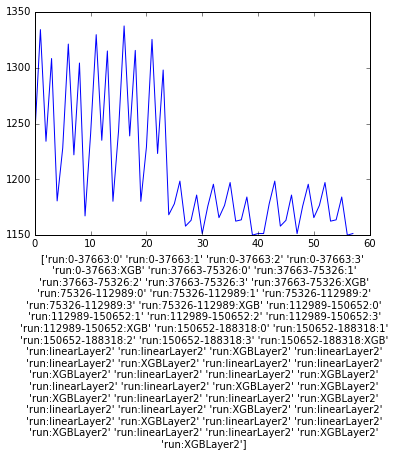

In [49]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)

plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [45]:
x_layer2_test = []
start_time1 = time.time()
for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
    start_time = time.time()            
    estimator=skclone(regrList[i], safe=True)
    print(estimator)
    estimator.fit(x,y) # use the estimator from the training, but refit to the whole data set!
    curr_predict=estimator.predict(x_test_data)
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
    
    if x_layer2_test == []:
        x_layer2_test = np.array(curr_predict.copy())
    else:
        x_layer2_test = np.column_stack((x_layer2_test,curr_predict))

#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
if use_xgb == True:
    gbdt=xgbfit(x,y)
    dtest = xgb.DMatrix(x_test_data)
    # now do a prediction and spit out a score(MAE) that means something
    #start_time = time.time()
    curr_predict=gbdt.predict(dtest)
    x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    #print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i+1] - y_test))))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

# add an avged column of all the runs
avg_column=np.mean(x_layer2_test, axis=1)
x_layer2_test=np.column_stack((x_layer2_test,avg_column))
print("AVG column added - length of new row: {}".format(len(x_layer2[0])))

print("Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)


KeyboardInterrupt: 

In [ ]:
start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2_test)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
display("Clusters sample:",final_clusters[:15])

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))

x_layer2_test=np.column_stack((x_layer2_test,final_clusters))

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))
print("run time:{}s".format(round((time.time()-start_time), 3) ))   

### Layer 2 predictions!

In [ ]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



### Predict Layer 3

In [39]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['loss']=layer3_gbdt.predict(dtest)

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1643.59790039\n',
 '6,2007.50891113\n',
 '9,8909.9375\n',
 '12,5939.16650391\n']

In [40]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1964.057617
dtype: float32)


# EOF 